In [40]:
from pypylon import pylon as py
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

## This notebook demonstrates how to configure a Basler camera for HDR imaging using the sequencer mode.

## Part 1: Configure the camera and capture images

In [30]:
# example Exposure times in microseconds
exposure_times_us = [500, 5000, 50000, 500000]
destination_folder = Path("raw_image")

# ensure the destination folder exists
Path(destination_folder).mkdir(parents=True, exist_ok=True)

In [43]:
# use the Basler Pylon SDK to access the camera
camera = py.InstantCamera(py.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

In [44]:
# Setup the camera to use 12 Bit pixel format and linear image to avoid any gamma correction
camera.PixelFormat.SetValue("BayerRG8")
camera.Gamma.SetValue(1.0)
# camera.ExposureAuto.SetValue("Off")

# only mono images are supported by the example transformation,
# but if you try this with a color camera, you have to disable color processing

try:
    camera.BslColorSpace.SetValue("Off")
    camera.BalanceWhiteAuto.SetValue("Off")
except py.LogicalErrorException as error:
    print(f"Camera does not support color processing, skipping color space configuration.{error}")
    # The camera does not support color processing, so we can ignore this error
    pass

In [4]:
# Configure the sequencer mode to set up the exposure times
try:
    # disable the sequencer mode if it is already active and enter configuration mode
    camera.SequencerMode.Value = "Off"
    camera.SequencerConfigurationMode.Value = "On"

    # Set the exposure time for each sequencer set
    for set_index, exposure_time in enumerate(exposure_times_us):
        # Load the current sequencer set
        camera.SequencerSetSelector.Value = set_index
        #camera.SequencerSetLoad.Execute()
        # Set the exposure time for the current sequencer set
        camera.ExposureTime.Value = exposure_time
        # setup the path for the sequencer, return to the first set after the last one
        camera.SequencerSetNext.Value = set_index + 1 if set_index < len(exposure_times_us) - 1 else 0
        # Change the sequencer to next set after the beginning of the exposure
        camera.SequencerTriggerSource.Value = "ExposureStart"
        # save the sequencer set before configure the next one in the loop
        camera.SequencerSetSave.Execute()

    # Setup of the sequencer is done, quit configuration mode
    camera.SequencerConfigurationMode.Value = "Off"
except py.LogicalErrorException as error:
    print("Camera does not support sequencer configuration mode.")
    camera.Close()
    exit(1)

In [45]:

# use burst mode to grab all images with one (software) trigger
camera.AcquisitionBurstFrameCount.SetValue(len(exposure_times_us))
camera.TriggerSelector.SetValue("FrameBurstStart")
camera.TriggerMode.SetValue("On")
camera.TriggerSource.SetValue("Software")

# activate the sequencer mode
camera.SequencerMode.SetValue("On")

# calculate the timeout for the grab operation,
# in sequencer mode the camera will report the lowest fps based on the settings,
# use this value plus a margin to avoid timeout errors
timeout_ms = int(1000 / camera.BslResultingTransferFrameRate.Value + 1000)


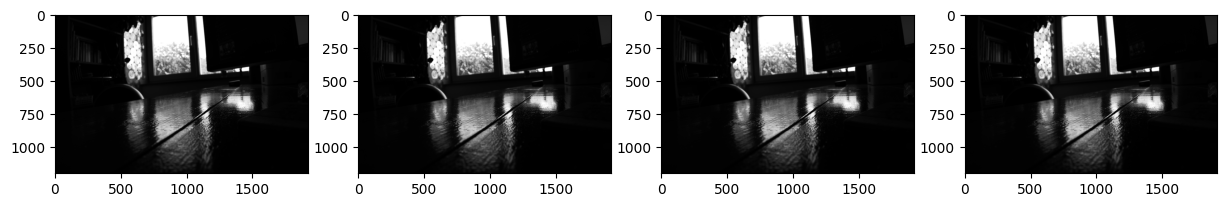

In [46]:
# finally, start the camera grabbing process and trigger the burst

py_image = py.PylonImage()
try:
    camera.StartGrabbing(py.GrabStrategy_OneByOne)
    camera.ExecuteSoftwareTrigger()


    # grab the images and save them to disk
    plt.figure(figsize=(15, 3))
    for i in range(len(exposure_times_us)):
        with camera.RetrieveResult(timeout_ms, py.TimeoutHandling_ThrowException) as grab_result:
            if grab_result.GrabSucceeded():
                py_image.AttachGrabResultBuffer(grab_result)
                py_image.Save(imageFileFormat=py.ImageFileFormat_Tiff,
                              filename=f"raw_image/img_{exposure_times_us[i]}us.tiff")
                plt.subplot(1, len(exposure_times_us), i + 1)
                plt.imshow(cv2.cvtColor(grab_result.Array, cv2.COLOR_BGR2RGB))
            else:
                print(f"Error: {grab_result.ErrorCode} - {grab_result.ErrorDescription}")
    # release the image and stop the camera
finally:
    py_image.Release()
    camera.StopGrabbing()


In [15]:
# close the camera connection
camera.Close()

## Part 2: Load the images and create an HDR image

In [9]:
import numpy as np
import cv2
import re
from pathlib import Path

In [10]:
# --- Step 1: Find all TIFF images in the 'raw_image' folder ---
image_dir = Path(destination_folder)
image_paths = sorted(image_dir.glob("*.tif*"))

images = []
exposures_us = []

In [11]:
# --- Step 2: Load images and extract exposure times from filenames ---
for path in image_paths:
    # Load 16-bit image
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Could not load image: {path}")
    img = (img >> 4)  #

    images.append(img)

    # Extract exposure time from filename (e.g. 'img_33000us.tiff')
    match = re.search(r"(\d+)us", path.name)
    if not match:
        raise ValueError(f"Filename does not contain exposure time: {path.name}")
    exposures_us.append(int(match.group(1)))

print(f"Loaded {len(images)} images with exposure times: {exposures_us}")

Loaded 4 images with exposure times: [500000, 50000, 5000, 500]


In [12]:
# --- Step 3: Stack and normalize images to float32 in range [0, 1] ---
ldr_stack = np.stack(images, axis=-1).astype(np.float32) / 4095.0
exposure_times = np.array(exposures_us, dtype=np.float32) / 1e6  # µs to s

In [13]:
# --- Step 4: Define triangle weighting function to suppress over/underexposed pixels ---
def weight_func(z):
    return z * (1.0 - z)

weights = weight_func(ldr_stack)
weights[weights == 0] = 1e-4  # avoid divide-by-zero

In [14]:

# --- Step 5: Compute HDR image as weighted radiance map ---
hdr_numerator = np.sum(weights * ldr_stack / exposure_times.reshape((1, 1, -1)), axis=2)
hdr_denominator = np.sum(weights, axis=2)
hdr_denominator[hdr_denominator == 0] = 1e-4  # prevent division by zero
hdr_image = hdr_numerator / hdr_denominator

In [15]:
# --- Step 6: Clean up invalid values (NaN, inf) ---
hdr_image = np.nan_to_num(hdr_image, nan=0.0, posinf=1.0, neginf=0.0)

In [16]:
# --- Step 7: Convert grayscale HDR image to 3-channel format for OpenCV tonemap ---
hdr_3ch = np.stack([hdr_image] * 3, axis=-1).astype(np.float32).copy()

In [17]:
# --- Step 8: Tonemap using OpenCV (Reinhard operator) ---
tonemap = cv2.createTonemapReinhard(gamma=1.0, intensity=0.0, light_adapt=1.0, color_adapt=0.0)
ldr_tonemapped = tonemap.process(hdr_3ch)
ldr_tonemapped = np.nan_to_num(ldr_tonemapped, nan=0.0, posinf=1.0, neginf=0.0)

In [18]:
# --- Step 9: Scale to 8-bit image for saving or display ---
ldr_8bit = (ldr_tonemapped * 255).clip(0, 255).astype(np.uint8)


In [19]:
np.min(ldr_8bit)

np.uint8(0)

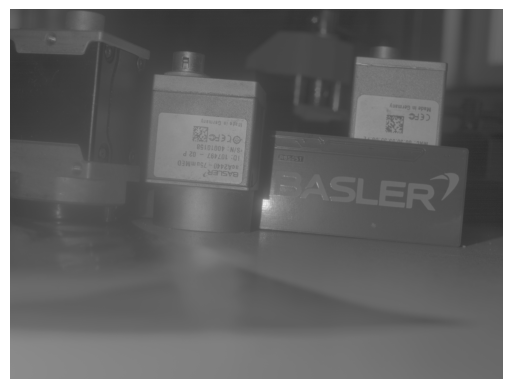

In [20]:
# --- Step 10: Display and save the result ---
cv2.imwrite((destination_folder / "ldr_result.png").absolute(), ldr_8bit)

plt.imshow(ldr_8bit, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()